In [1]:
import numpy as np
import pandas as pd

In [2]:
files_name=[]
for i in range(303,383,10):
    name=str(i)+'.15_0.58.out'
    files_name.append(name)

In [3]:
for filename in files_name:
    df_name = 'df_' + filename.split('.')[0] # 根据文件名生成dataframe的名称
    #print(df_name)
    df = pd.read_table(filename, sep='\s+',header=None, engine='python') # 读取文件并转换为dataframe
    df=df.astype('float64')
    globals()[df_name] = df

In [4]:
df_name=[]
for i in range(303,383,10):
    name='df_'+str(i)
    df_name.append(name)

In [5]:
df_list = [globals()[name.replace("'", "")] for name in df_name]

In [6]:
temperature=[]
for i in range(303,383,10):
    tem=i+0.15
    temperature.append(tem)

In [7]:
for i, df in enumerate(df_list):
    df['temperature'] = temperature[i]
    #df=df.astype('float64')

In [8]:
from paddlets import TSDataset
def get_teddataset(df):
    tsdataset= TSDataset.load_from_dataframe(
        df=df,
        group_id='temperature',
        time_col=0,
        target_cols=list(range(1, 286)),
        static_cov_cols='temperature'
    )
    return tsdataset

PLEASE USE OMP_NUM_THREADS WISELY.
/root/miniconda3/lib/python3.8/site-packages/paddlets/utils/backtest.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import defaultdict, Iterable


In [9]:
def dataset_split(tsdataset):
    train_dataset, val_test_dataset = tsdataset.split(0.8)
    val_dataset, test_dataset = val_test_dataset.split(0.5)
    return train_dataset,val_dataset,test_dataset

In [10]:
def dataset_split_1(tsdataset):
    train_dataset1, val_dataset1 = tsdataset.split(0.1)
    return train_dataset1, val_dataset1

In [11]:
for i, df in enumerate(df_list):
    if (10*i+303)!=343:
        #tst_name='df_'+str(2i+303)+'_tstdataset'
        tst_train_name='df_train_'+str(10*i+303)+'_tstdataset'
        #print( tst_train_name)
        tst_valid_name='df_valid_'+str(10*i+303)+'_tstdataset'
        tst_test_name='df_test_'+str(10*i+303)+'_tstdataset'
        tstdataset=get_teddataset(df)
        #globals()[tst_name] = tstdataset
        df_train_dataset,df_val_dataset,df_test_dataset=dataset_split(tstdataset)
        globals()[tst_train_name] = df_train_dataset
        globals()[tst_valid_name] = df_val_dataset
        globals()[tst_test_name] = df_test_dataset
    else:
        tstdataset=get_teddataset(df_343)
        df_train_343_dataset,df_val_343_dataset=dataset_split_1(tstdataset)       

In [12]:
tst_train_name=[]
tst_valid_name=[]
tst_test_name=[]
for i in range(0,8):
    if (10*i+303)!=343:
        train_name='df_train_'+str(10*i+303)+'_tstdataset'
        tst_train_name.append(train_name)
        valid_name='df_valid_'+str(10*i+303)+'_tstdataset'
        tst_valid_name.append(valid_name)
        test_name='df_test_'+str(10*i+303)+'_tstdataset'
        tst_test_name.append(test_name)
tst_train_list = [globals()[name.replace("'", "")] for name in tst_train_name]
tst_valid_list = [globals()[name.replace("'", "")] for name in tst_valid_name] 
tst_test_list = [globals()[name.replace("'", "")] for name in tst_test_name] 

In [13]:
tst_train_list[0].dtypes

1              float64
2              float64
3              float64
4              float64
5              float64
                ...   
282            float64
283            float64
284            float64
285            float64
temperature    float64
Length: 286, dtype: object

In [14]:
from paddlets.transform import Fill, StandardScaler,MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(tst_train_list)
train_dataset_scaled = scaler.transform(tst_train_list)
#val_test_dataset_scaled = scaler.transform(val_test_dataset)
val_dataset_scaled = scaler.transform(tst_valid_list)
test_dataset_scaled = scaler.transform(tst_test_list)

In [15]:
df_train_343_dataset_scaled=scaler.transform(df_train_343_dataset)
df_val_343_dataset_scaled=scaler.transform(df_val_343_dataset)

In [16]:
from paddlets.models.forecasting import LSTNetRegressor
import paddle.nn.functional as F
lst = LSTNetRegressor(in_chunk_len=150, out_chunk_len=150,loss_fn=F.mse_loss1,optimizer_params=dict(learning_rate=5e-4))
#lst.fit(tst_train_list, tst_valid_list)
lst.fit(train_dataset_scaled, val_dataset_scaled)
#rnn_reg.fit(df_train_tsdatasets, df_val_tsdatasets)

W0306 16:50:52.470708 10753 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 8.6, Driver API Version: 12.2, Runtime API Version: 11.2
W0306 16:50:52.473053 10753 gpu_resources.cc:91] device: 0, cuDNN Version: 8.1.
W0306 16:50:52.858073 10753 gpu_resources.cc:217] WARNING: device:  . The installed Paddle is compiled with CUDNN 8.2, but CUDNN version in your machine is 8.1, which may cause serious incompatible bug. Please recompile or reinstall Paddle with compatible CUDNN version.
[2024-03-06 16:51:00,161] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 000| loss: 1.138472| val_0_mae: 0.535334| 0:00:07s
[2024-03-06 16:51:05,152] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 001| loss: 0.440766| val_0_mae: 0.527723| 0:00:12s
[2024-03-06 16:51:10,254] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 002| loss: 0.482210| val_0_mae: 0.528235| 0:00:17s
[2024-03-06 16:51:15,097] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 003| l

In [17]:
subset_val_pred_dataset_2_scaled = lst.recursive_predict(df_train_343_dataset_scaled,2500)
subset_val_dataset_2_scaled, _ = df_val_343_dataset_scaled.split(len(subset_val_pred_dataset_2_scaled.target))

In [18]:
val_predict_2 = subset_val_pred_dataset_2_scaled[list(range(1, 286))]
val_real_2=subset_val_dataset_2_scaled[list(range(1, 286))]
val_predict_2['Mn'] = val_predict_2.sum(axis=1) / 285
val_real_2['Mn'] = val_real_2.sum(axis=1) / 285

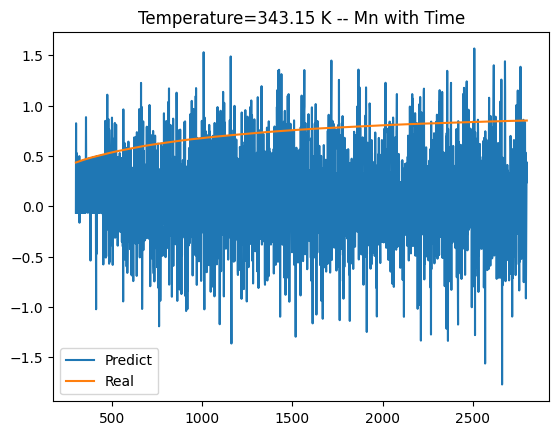

In [19]:
import matplotlib.pyplot as plt
plt.plot(val_predict_2.index, val_predict_2['Mn'], label='Predict')
plt.plot(val_real_2.index, val_real_2['Mn'], label='Real')
plt.legend()
plt.title('Temperature=343.15 K -- Mn with Time')
plt.show()

In [20]:
subset_val_pred_dataset_2_new=scaler.inverse_transform(subset_val_pred_dataset_2_scaled)
subset_val_dataset_2_new=scaler.inverse_transform(subset_val_dataset_2_scaled)
val_predict_2 = subset_val_pred_dataset_2_new[list(range(1, 286))]
val_real_2=subset_val_dataset_2_new[list(range(1, 286))]
val_predict_2['Mn'] = val_predict_2.sum(axis=1) / 285
val_real_2['Mn'] = val_real_2.sum(axis=1) / 285

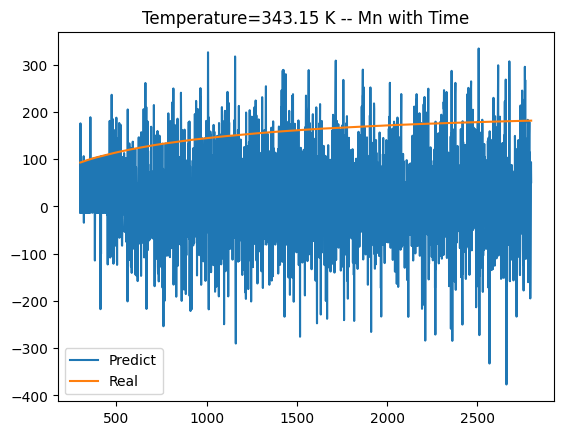

In [21]:
import matplotlib.pyplot as plt
plt.plot(val_predict_2.index, val_predict_2['Mn'], label='Predict')
plt.plot(val_real_2.index, val_real_2['Mn'], label='Real')
plt.legend()
plt.title('Temperature=343.15 K -- Mn with Time')
plt.show()

In [26]:
df_list[0]

,0,1,2,3,4,5,6,7,8,9,...,279,280,281,282,283,284,285,286,287,temperature
0,10.0072,3,9,2,3,3,6,3,1,1,...,10,3,6,1,2,1,1,1,286,303.15
1,20.0072,3,9,5,5,7,7,7,4,3,...,10,5,9,10,4,4,1,5,286,303.15
2,30.0092,3,10,7,5,12,9,7,8,3,...,11,8,9,11,8,5,3,9,286,303.15
3,40.0097,4,11,7,7,13,12,7,9,4,...,13,9,11,11,8,5,3,10,286,303.15
4,50.0100,8,13,7,7,14,14,9,10,6,...,13,13,12,13,9,6,3,14,286,303.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2992,29955.0000,183,171,207,209,186,174,187,198,209,...,22,184,213,201,217,219,17,34,286,303.15
2993,29965.0000,183,171,207,209,186,174,187,198,209,...,22,184,213,201,217,219,17,34,286,303.15
2994,29975.0000,183,171,207,209,186,174,187,198,209,...,22,184,213,201,217,219,17,34,286,303.15
2995,29985.0000,183,171,207,209,186,174,187,198,209,...,22,184,213,201,217,219,17,34,286,303.15


In [21]:
df_313

,0,1,2,3,4,5,6,7,8,9,...,279,280,281,282,283,284,285,286,287,temperature
0,10.0065,0,1,4,1,2,0,1,4,3,...,0,5,7,4,9,2,10,0,286,313.15
1,20.0074,8,4,5,4,5,1,3,9,5,...,4,5,7,5,9,4,10,0,286,313.15
2,30.0077,10,6,5,4,6,2,7,11,5,...,7,6,8,5,9,5,10,1,286,313.15
3,40.0122,10,6,5,4,6,5,7,14,6,...,7,6,8,7,13,6,11,1,286,313.15
4,50.0180,10,6,5,5,6,5,7,16,6,...,8,10,9,8,14,6,14,2,286,313.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2992,29955.1000,197,194,5,206,194,217,208,62,212,...,190,208,194,211,203,209,173,165,286,313.15
2993,29965.1000,197,194,5,206,194,217,208,62,212,...,190,208,194,211,203,210,173,165,286,313.15
2994,29975.1000,197,194,5,206,194,217,209,62,212,...,190,208,194,211,203,210,173,165,286,313.15
2995,29985.1000,197,194,5,206,194,217,209,62,212,...,190,208,194,211,203,210,173,165,286,313.15
